In [1]:
import freegs
from freegs import optimise as opt
from freegs.machine import Coil, Solenoid, Wall

In [2]:
PR1 = 0.50738376
PZ1 = 0.39384023
PR2 = 0.62576723
PZ2 = 0.1996288

In [3]:
poloidal_coils = [
    ("VERT_U", Coil(PR1, PZ1)),
    ("VERT_L", Coil(PR1, -PZ1)),
    ("HORIZ_U", Coil(PR2, PZ2)),
    ("HORIZ_L", Coil(PR2, -PZ2))
]

In [4]:
solenoid_height = 0.94
inner_radius = 51e-3
outer_radius = 60e-3
solenoid_turns = 104

In [5]:
central_solenoid = [("SOL", Solenoid((inner_radius + outer_radius) / 2, -solenoid_height / 2,  solenoid_height / 2, solenoid_turns, control=False))]

In [6]:
walls = Wall(
    [0.160,0.1761,0.2200,0.280,0.3400,0.3839,0.40, 0.3839, 0.3400, 0.280, 0.2200, 0.1761 ],   # R
    [0.000,0.0600,0.1039,0.120,0.1039,0.0600,0.00,-0.0600,-0.1039,-0.120,-0.1039,-0.0600]     # Z
)

In [7]:
tokamak = freegs.machine.Machine(
    central_solenoid + poloidal_coils,
    walls
)

In [8]:
tokamak['VERT_U'].area = tokamak['VERT_L'].area = tokamak['HORIZ_U'].area = tokamak['HORIZ_L'].area =  0.000213825*4

In [9]:
eq = freegs.Equilibrium(tokamak=tokamak,
                        Rmin=0.01, Rmax=0.6,    # Radial domain
                        Zmin=-0.5, Zmax=0.5,   # Height range
                        nx=65, ny=65          # Number of grid points
                        )

In [10]:
plasma_major_radius = 0.28
toroidal_magnetic_field_strength_at_plasma_centre = 0.875
vacuum_toroidal_magnetic_field = plasma_major_radius * toroidal_magnetic_field_strength_at_plasma_centre

In [11]:
profiles = freegs.jtor.ConstrainBetapIp(eq,
                                        0.05, # Plasma poloidal beta
                                        3e3, # Plasma current [Amps]
                                        vacuum_toroidal_magnetic_field) # Vacuum f=R*Bt

In [12]:
xpoints = [(0.3, -0.24), (0.3, 0.24)]  # (R,Z) locations of X-points

isoflux = [(0.3, -0.24, 0.3, 0.24)] # (R1,Z1, R2,Z2) pairs

In [13]:
constrain = freegs.control.constrain(xpoints=xpoints, isoflux=isoflux)

In [14]:
freegs.solve(eq,
            profiles, 
            constrain,
            show=False,
            check_limited=True,
            limit_it = 0
)

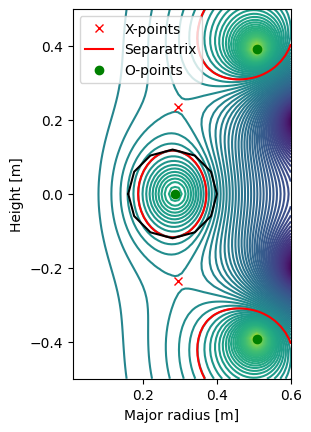

<Axes: xlabel='Major radius [m]', ylabel='Height [m]'>

In [17]:
eq.plot()

In [15]:
eq.printForces()

Forces on coils
SOL (circuit)
VERT_U : R = -0.00 kN , Z = 0.02 kN
VERT_L : R = -0.00 kN , Z = -0.02 kN
HORIZ_U : R = 0.03 kN , Z = -0.02 kN
HORIZ_L : R = 0.03 kN , Z = 0.02 kN


In [16]:
tokamak.printCurrents()

SOL : Solenoid(Rs=0.055499999999999994, Zsmin=-0.47, Zsmax=0.47, current=0.0, Ns=104, control=False)
VERT_U : Coil(R=0.50738376, Z=0.39384023, current=2588.7, turns=1, control=True)
VERT_L : Coil(R=0.50738376, Z=-0.39384023, current=2588.7, turns=1, control=True)
HORIZ_U : Coil(R=0.62576723, Z=0.1996288, current=-2800.7, turns=1, control=True)
HORIZ_L : Coil(R=0.62576723, Z=-0.1996288, current=-2800.7, turns=1, control=True)


In [17]:
def optimise_tokamak(equilibrium):
    best_eq = opt.optimise(equilibrium,  # Starting equilibrium
                           # List of controls
                           [
                               opt.CoilRadius('VERT_U'),
                               opt.CoilRadius('VERT_L'),
                               opt.CoilRadius('HORIZ_U'),
                               opt.CoilRadius('HORIZ_L'),
                               opt.CoilHeight('VERT_U'),
                               opt.CoilHeight('VERT_L'),
                               opt.CoilHeight('HORIZ_U'),
                               opt.CoilHeight('HORIZ_L')
                           ],
                           # The function to minimise
                           opt.weighted_sum(opt.max_abs_coil_current, opt.no_wall_intersection),
                           N=10,  # Number of solutions in each generation
                           maxgen=20,  # How many generations
                           monitor=opt.PlotMonitor())  # Plot the best in each generation
    return best_eq

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2599702542.py, line 5)

In [ ]:
print('Start Optimisation')
best_eq = optimise_tokamak(eq)
print('End Optimisation')

In [ ]:
best_eq.printForces()
best_eq.plot()

In [ ]:
best_eq.tokamak.coils